In [11]:
import os
import scipy.io as sio
import skimage.registration
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [29]:
import os
import glob

import numpy as np
import scipy.io as sio
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf

import time

from src.new_model import *
from skimage.draw import  circle


In [13]:
obj_dims = (648, 486)
BATCH_SIZE = 4

test_files = np.array(sorted(glob.glob('../data/main_dataset/test/*'))[10])
# Whether to save ground truths to results directory (set False to save time).
save_gts_flag = False

# Registered PSFs

In [14]:
out_dir = '../results/figures/architecture_diagram'
os.makedirs(out_dir, exist_ok=True)

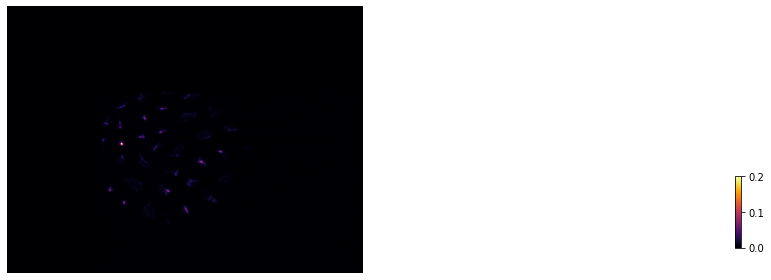

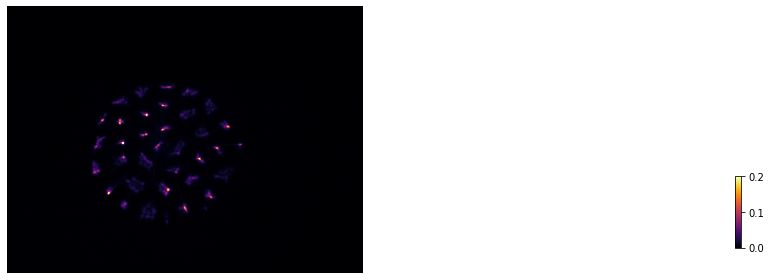

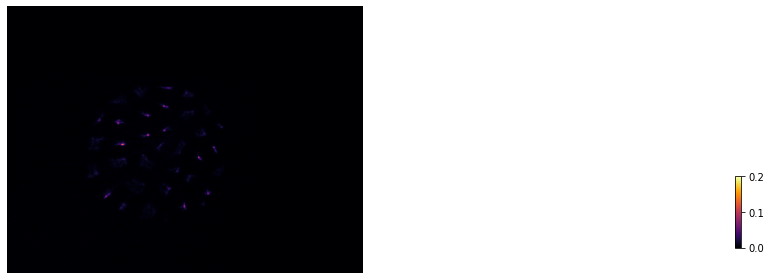

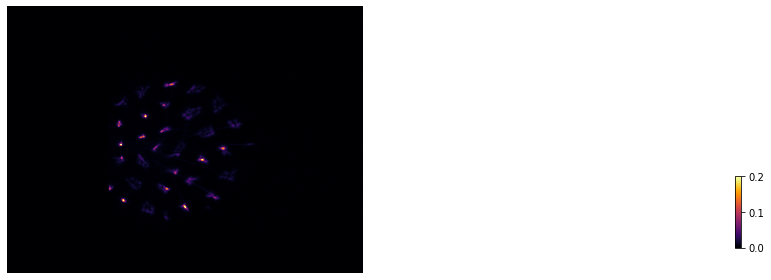

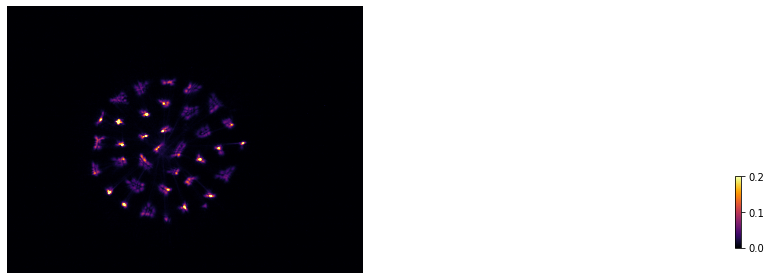

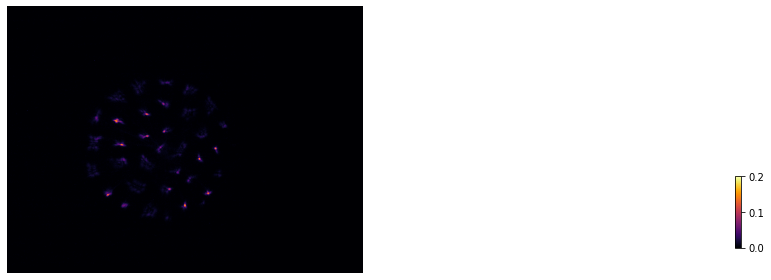

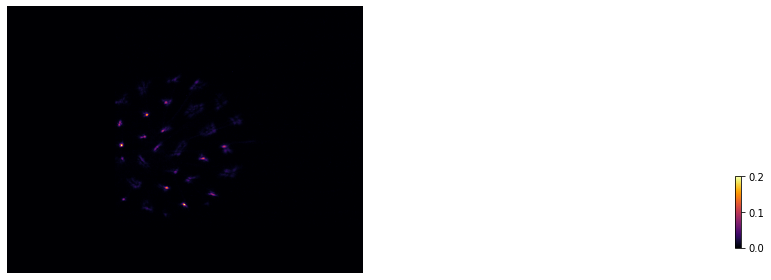

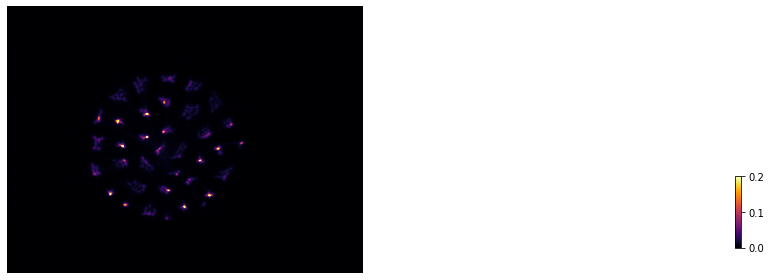

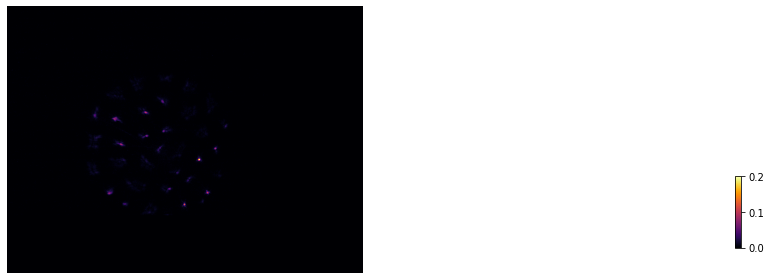

In [56]:
psfs_path = '/home/rshuai/research/u-net-reconstruction/data/PSFs/9_psfs/psfs_Z1_1_9.mat'

psfs = sio.loadmat(psfs_path)['psfs'].transpose(2, 1, 0)
assert psfs.shape == (9, 648, 486)

psfs = psfs / np.max(psfs)

num_psfs = psfs.shape[0]

central_psf = psfs[4]

shifts = []

for i in range(num_psfs):
    shift, error, diffphase = skimage.registration.phase_cross_correlation(central_psf, psfs[i])
    shifts.append(shift)
    
registered_psfs = np.zeros_like(psfs)
_, h, w = psfs.shape

for i in range(num_psfs):
    # Build translation matrix
    shift = shifts[i]
    shift_x = shift[1]
    shift_y = shift[0]
    translation_matrix = np.array([[1, 0, shift_x],
                                    [0, 1, shift_y]])
    
    # Translate image with cv2
    registered_psfs[i] = cv2.warpAffine(psfs[i], translation_matrix, (w, h))
    
#     s = fig.add_subplot(rows, columns, columns*i+1)
#     s.set_title('PSF {}'.format(i), size=10)
#     plt.imshow(psfs[i], cmap='inferno')
    
#     s = fig.add_subplot(rows, columns, columns*i+2)
#     s.set_title('Registered PSF {}'.format(i), size=10)
    fig = plt.figure()
    plt.axis('off')
    plt.tight_layout()
    im = plt.imshow(registered_psfs[i].T, cmap='inferno', vmin=0, vmax=0.2)
    cbar_ax = fig.add_axes([1.773, 0.125, 0.015, 0.247])
    cbar = plt.colorbar(im, cax=cbar_ax)
    plt.savefig(os.path.join(out_dir, 'psf_{}.png'.format(i)), bbox_inches='tight')
    plt.show()
    
#     fig = plt.figure()
#     plt.axis('off')
#     plt.tight_layout()
#     im = plt.imshow(psfs[i].T, cmap='inferno', vmin=0, vmax=0.05)
#     cbar_ax = fig.add_axes([1.773, 0.125, 0.015, 0.247])
#     cbar = plt.colorbar(im, cax=cbar_ax)
#     plt.savefig(os.path.join(out_dir, 'unregistered_psf_{}.png'.format(i)), bbox_inches='tight')
#     plt.show()
    
#     fig = plt.figure()
#     plt.axis('off')
#     plt.tight_layout()
#     z = np.zeros(psfs[i].shape)
#     rr, cc = circle(int(z.shape[1] // 2 - shift_y), int(z.shape[0] // 2 - shift_x), 5, z.shape)
#     z[rr, cc] = 1
#     im = plt.imshow(z.T, cmap='inferno', vmin=0, vmax=1)
#     cbar_ax = fig.add_axes([0.773 + 0.5, 0.125, 0.015, 0.247])
#     cbar = plt.colorbar(im, cax=cbar_ax)
#     plt.savefig(os.path.join(out_dir, 'point_source_{}.png'.format(i)), bbox_inches='tight')
#     plt.show()

# Get prediction and Wiener prediction

In [6]:
def _parse_function(example_proto):
    feature_description = {
        'plane': tf.io.FixedLenFeature(obj_dims, tf.float32),
        'sim': tf.io.FixedLenFeature(obj_dims, tf.float32)
        
    }
    example = tf.io.parse_single_example(example_proto, feature_description)
    plane = example['plane']
    plane_max = tf.reduce_max(plane)
    plane_min = tf.reduce_min(plane)
    plane = (plane - plane_min) / (plane_max - plane_min)  # Normalize values to [0, 1]

    sim = example['sim']
    sim_max = tf.reduce_max(sim)
    sim_min = tf.reduce_min(sim)
    sim = (sim - sim_min) / (sim_max - sim_min)  # Normalize values to [0, 1]

    # Expand to channel dimension
    sim = sim[..., tf.newaxis]
    
    return sim, plane

def create_dataset(filenames, batch_size):
    """
    Takes in string array of filenames for TFRecord files containing samples.
    Returns: TFRecordDataset with given batch size
    """
    raw_dataset = tf.data.TFRecordDataset(filenames)
    dataset = raw_dataset.map(_parse_function)
    dataset = dataset.batch(batch_size)
    
    return dataset

In [7]:
test_dataset = create_dataset(test_files, BATCH_SIZE)

In [8]:
ground_truths = np.zeros((1, 648, 486))
sims = np.zeros((1, 648, 486))

for i, (sim, plane) in enumerate(test_dataset.unbatch()):
    ground_truths[i] = plane.numpy().squeeze()
    sims[i] = sim.numpy().squeeze()

## Load in model, get output

In [9]:
# psfs = np.zeros((648, 486, 9))
# Ks = np.zeros((1, 1, 9))
# model = UNet_multiwiener_resize(648, 486, psfs, Ks,
#                          encoding_cs=[24, 64, 128, 256, 512, 1024],
#                          center_cs=1024,
#                          decoding_cs=[512, 256, 128, 64, 24, 24],
#                          skip_connections=[True, True, True, True, True, False])


# model.load_weights('../models/model_final_5/model_final_5.best')
# preds_multi = np.clip(model.predict(test_dataset), 0, 1)

In [10]:
psf = np.zeros((648, 486))
K = 0
model = UNet_wiener(648, 486, psf, K,
                         encoding_cs=[24, 64, 128, 256, 512, 1024],
                         center_cs=1024,
                         decoding_cs=[512, 256, 128, 64, 24, 24],
                         skip_connections=[True, True, True, True, True, False])


model.load_weights('../models/model_final_2/model_final_2.best')
preds_multi = np.clip(model.predict(test_dataset), 0, 1)

## Get Wiener outputs

In [11]:
from tensorflow.keras.models import Model

In [12]:
model_wiener = Model(model.input, model.layers[1].output)
preds_multi_wiener_outs = model_wiener.predict(test_dataset)

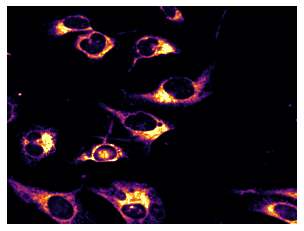

In [13]:
plt.tight_layout()
plt.imshow(ground_truths[0].T, vmin=0, vmax=0.5, cmap='inferno')
plt.axis('off')
plt.savefig('../results/figures/architecture_diagram/gt.png', bbox_inches='tight')

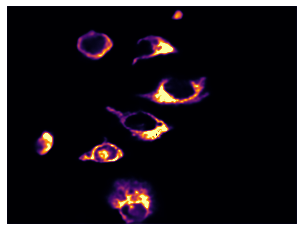

In [14]:
plt.tight_layout()
plt.imshow(preds_multi[0].T, vmin=0, vmax=0.5, cmap='inferno')
plt.axis('off')
plt.savefig('../results/figures/architecture_diagram/pred.png', bbox_inches='tight')

In [15]:
# for i in range(9):
#     plt.tight_layout()
#     plt.imshow(preds_multi_wiener_outs[0, :, :, i].T, cmap='inferno')
#     plt.axis('off')
#     plt.savefig('../results/figures/architecture_diagram/wiener_out{}.png'.format(i), bbox_inches='tight')

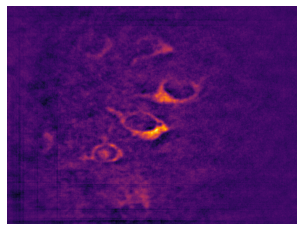

In [16]:
for i in range(1):
    plt.tight_layout()
    plt.imshow(preds_multi_wiener_outs[0, :, :, i].T, cmap='inferno')
    plt.axis('off')
    plt.savefig('../results/figures/architecture_diagram/wiener_out{}.png'.format(i), bbox_inches='tight')

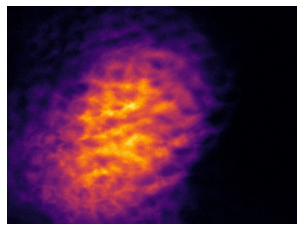

In [17]:
plt.tight_layout()
plt.imshow(sims[0].T, cmap='inferno')
plt.axis('off')
plt.savefig('../results/figures/architecture_diagram/sim.png', bbox_inches='tight')